#Etapa 1: Importação das bibliotecas

In [1]:
import numpy as np # acesso a vetores
import math # função matematicas
import re # expressão regulares
from bs4 import BeautifulSoup # pré processamentos dos dados
import random # números aleatorios
import seaborn as sns # geração de graficos
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=5efaff0a36ee06d0773b7f922b5231c85b31cbdff9d5ea6fa85e00f901ce4b88
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=d3b1d548c696d5a7c06b67401481ecacfeb16f34682f865dd26a8b7f98c2467a
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=7967706153b30f1a6f2c7462e686b9584c2835489bfe50e7fa85dc920bd51715
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 6.4MB/s 


In [4]:
%tensorflow_version 2.x

In [76]:

import tensorflow as tf


In [43]:
!pip install tensorflow-hub

    100% |████████████████████████████████| 102kB 761kB/s a 0:00:01


In [44]:
import tensorflow_hub as hub

In [45]:
from tensorflow.keras import layers
import bert

## Carregamento da base de dados

In [181]:
data = pd.read_csv('train.csv')

In [182]:
data.head(7)

text sentiment
0  Now, I won't deny that when I purchased this o...       neg
1  The saddest thing about this "tribute" is that...       neg
2  Last night I decided to watch the prequel or s...       neg
3  I have to admit that i liked the first half of...       neg
4  I was not impressed about this film especially...       neg
5  The original movie, The Odd Couple, has some w...       pos
6  This was a great movie with a good cast, all o...       pos

In [183]:
data.tail()

text sentiment
24995  This film is fun, if your a person who likes a...       pos
24996  After seeing this film I feel like I know just...       pos
24997  first this deserves about 5 stars due to actin...       neg
24998  If you like films that ramble with little plot...       neg
24999  As interesting as a sheet of cardboard, this d...       neg

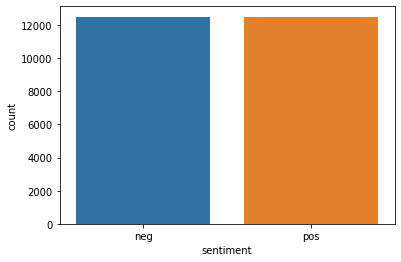

In [184]:
sns.countplot(data['sentiment']);

# Etapa 2: Pré-processamento

## Limpeza dos texto

In [185]:
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+",' ', tweet)
  tweet = re.sub(r'https?://[A-Za-z0-9./]+', ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?' ]", ' ', tweet)
  tweet = re.sub(r" +",' ', tweet)
  return tweet

In [187]:
test = data.text.tolist()[0]
test

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

In [188]:
result = clean_tweet(test)
result

"Now I won't deny that when I purchased this off eBay I had high expectations. This was an incredible out of print work from the master of comedy that I so enjoy. However I was soon to be disappointed. Apologies to those who enjoyed it but I just found the Compleat Al to be very difficult to watch. I got a few smiles sure but the majority of the funny came from the music videos which I've got on DVD and the rest was basically filler. You could tell that this was not Al's greatest video achievement that honor goes to UHF . Honestly I doubt if this will ever make the jump to DVD so if you're an ultra hardcore Al fan and just HAVE to own everything buy the tape off eBay. Just don't pay too much for it."

In [189]:
data_clean = data.text.apply(clean_tweet)
data_clean[0]

"Now I won't deny that when I purchased this off eBay I had high expectations. This was an incredible out of print work from the master of comedy that I so enjoy. However I was soon to be disappointed. Apologies to those who enjoyed it but I just found the Compleat Al to be very difficult to watch. I got a few smiles sure but the majority of the funny came from the music videos which I've got on DVD and the rest was basically filler. You could tell that this was not Al's greatest video achievement that honor goes to UHF . Honestly I doubt if this will ever make the jump to DVD so if you're an ultra hardcore Al fan and just HAVE to own everything buy the tape off eBay. Just don't pay too much for it."

In [234]:
data_labels = data.sentiment.values
data_labels

array(['neg', 'neg', 'neg', ..., 'neg', 'neg', 'neg'], dtype=object)

In [235]:
data_labels[data_labels == 'neg'] = 0
data_labels[data_labels == 'pos'] = 1
data_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

## Tokenização

In [57]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=False) # 24 camadas 1024 colunas 16 numeros de subespaços
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file,do_lower_case)

In [236]:
vocab_file

b'/tmp/tfhub_modules/88ac13afec2955fd14396e4582c251841b67429a/assets/vocab.txt'

In [237]:
print(tokenizer.vocab)

OrderedDict([('[PAD]', 0), ('[unused0]', 1), ('[unused1]', 2), ('[unused2]', 3), ('[unused3]', 4), ('[unused4]', 5), ('[unused5]', 6), ('[unused6]', 7), ('[unused7]', 8), ('[unused8]', 9), ('[unused9]', 10), ('[unused10]', 11), ('[unused11]', 12), ('[unused12]', 13), ('[unused13]', 14), ('[unused14]', 15), ('[unused15]', 16), ('[unused16]', 17), ('[unused17]', 18), ('[unused18]', 19), ('[unused19]', 20), ('[unused20]', 21), ('[unused21]', 22), ('[unused22]', 23), ('[unused23]', 24), ('[unused24]', 25), ('[unused25]', 26), ('[unused26]', 27), ('[unused27]', 28), ('[unused28]', 29), ('[unused29]', 30), ('[unused30]', 31), ('[unused31]', 32), ('[unused32]', 33), ('[unused33]', 34), ('[unused34]', 35), ('[unused35]', 36), ('[unused36]', 37), ('[unused37]', 38), ('[unused38]', 39), ('[unused39]', 40), ('[unused40]', 41), ('[unused41]', 42), ('[unused42]', 43), ('[unused43]', 44), ('[unused44]', 45), ('[unused45]', 46), ('[unused46]', 47), ('[unused47]', 48), ('[unused48]', 49), ('[unused49]

In [238]:
len(tokenizer.vocab)

30522

In [239]:
tokenizer.tokenize('You or me?') # Note a divisão de Token

['you', 'or', 'me', '?']

In [240]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize('You or me?'))

[2017, 2030, 2033, 1029]

In [241]:
def encode_sentence(sent):
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [242]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]
data_inputs

[[2085,
  1045,
  2180,
  1005,
  1056,
  9772,
  2008,
  2043,
  1045,
  4156,
  2023,
  2125,
  1041,
  15907,
  1045,
  2018,
  2152,
  10908,
  1012,
  2023,
  2001,
  2019,
  9788,
  2041,
  1997,
  6140,
  2147,
  2013,
  1996,
  3040,
  1997,
  4038,
  2008,
  1045,
  2061,
  5959,
  1012,
  2174,
  1045,
  2001,
  2574,
  2000,
  2022,
  9364,
  1012,
  25380,
  2000,
  2216,
  2040,
  5632,
  2009,
  2021,
  1045,
  2074,
  2179,
  1996,
  4012,
  10814,
  4017,
  2632,
  2000,
  2022,
  2200,
  3697,
  2000,
  3422,
  1012,
  1045,
  2288,
  1037,
  2261,
  8451,
  2469,
  2021,
  1996,
  3484,
  1997,
  1996,
  6057,
  2234,
  2013,
  1996,
  2189,
  6876,
  2029,
  1045,
  1005,
  2310,
  2288,
  2006,
  4966,
  1998,
  1996,
  2717,
  2001,
  10468,
  6039,
  2121,
  1012,
  2017,
  2071,
  2425,
  2008,
  2023,
  2001,
  2025,
  2632,
  1005,
  1055,
  4602,
  2678,
  6344,
  2008,
  3932,
  3632,
  2000,
  20131,
  1012,
  9826,
  1045,
  4797,
  2065,
  2023,
  2097,
  

## Criação da base dados

In [243]:
data_withn_len = [[sent, data_labels[i], len(sent)]
                  for i, sent in enumerate(data_inputs)]

In [244]:
data_withn_len[0:2]

[[[2085,
   1045,
   2180,
   1005,
   1056,
   9772,
   2008,
   2043,
   1045,
   4156,
   2023,
   2125,
   1041,
   15907,
   1045,
   2018,
   2152,
   10908,
   1012,
   2023,
   2001,
   2019,
   9788,
   2041,
   1997,
   6140,
   2147,
   2013,
   1996,
   3040,
   1997,
   4038,
   2008,
   1045,
   2061,
   5959,
   1012,
   2174,
   1045,
   2001,
   2574,
   2000,
   2022,
   9364,
   1012,
   25380,
   2000,
   2216,
   2040,
   5632,
   2009,
   2021,
   1045,
   2074,
   2179,
   1996,
   4012,
   10814,
   4017,
   2632,
   2000,
   2022,
   2200,
   3697,
   2000,
   3422,
   1012,
   1045,
   2288,
   1037,
   2261,
   8451,
   2469,
   2021,
   1996,
   3484,
   1997,
   1996,
   6057,
   2234,
   2013,
   1996,
   2189,
   6876,
   2029,
   1045,
   1005,
   2310,
   2288,
   2006,
   4966,
   1998,
   1996,
   2717,
   2001,
   10468,
   6039,
   2121,
   1012,
   2017,
   2071,
   2425,
   2008,
   2023,
   2001,
   2025,
   2632,
   1005,
   1055,
   4602,
   26

In [245]:
random.shuffle(data_withn_len) # misturar os dados
data_withn_len.sort(key=lambda x: x[2]) #x[2] tamanho da frase
sorted_all = [(sent_lab[0], sent_lab[1]) 
             for sent_lab in data_withn_len if sent_lab[2] > 0]


In [247]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, output_types =(tf.int32,tf.int32))

In [248]:
next(iter(all_dataset))

(<tf.Tensor: shape=(11,), dtype=int32, numpy=
 array([2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012],
       dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [249]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None,),())) # Pegar exatamente o que está na base de dados

In [250]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 32), dtype=int32, numpy=
 array([[ 2023,  3185,  2003, ...,     0,     0,     0],
        [ 1045,  2876,  1005, ...,     0,     0,     0],
        [ 7918, 14674,  7662, ...,     0,     0,     0],
        ...,
        [ 2020,  1045,  2025, ...,  1997,  3409,  1012],
        [ 2023,  2143,  2081, ...,  2008,  4368,  1012],
        [ 1996,  2069,  9487, ...,  3185,  3452,  1012]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0], dtype=int32)>)

In [252]:
NB_BATCHES = len(sorted_all) // BATCH_SIZE
NB_BATCHES

781

In [253]:
NB_BATCHES_TEST = NB_BATCHES // 10
NB_BATCHES_TEST

78

In [254]:
all_batched.shuffle(NB_BATCHES)

<ShuffleDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int32)>

In [255]:
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST) # pegar os registros tirando o que o teste já pegou 

# Construção do modelo

In [258]:
class DCNN(tf.keras.Model):
  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               FFN_units=512, # camada densa
               nb_classes=2,
               dropout_rate=0.1, # zerar 10 % dos neuronios
               training=False,
               name='dcnn'):
    super(DCNN,self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size,emb_dim) # Camada de entrada , recebendo as palavras e convertendo para embedding
    self.bigram = layers.Conv1D(filters= nb_filters,
                                kernel_size = 2,
                                padding = 'valid', # pode perder um pouco das dimensões 
                                activation='relu') # bi gramas camadas de convolução de duas linhas
    self.trigram = layers.Conv1D(filters= nb_filters,
                                kernel_size = 3,
                                padding = 'valid', # pode perder um pouco das dimensões 
                                activation='relu') # tri gramas camadas de convolução de tres linhas
    self.fourngram = layers.Conv1D(filters= nb_filters,
                                kernel_size = 4,
                                padding = 'valid', # pode perder um pouco das dimensões 
                                activation='relu') # quatro gramas camadas de convolução de quatro linhas
    
    self.pool = layers.GlobalMaxPool1D() # buscar o valor maximo de cada filtro

    self.dense_1 = layers.Dense(units= FFN_units, activation='relu') # camada densa
    self.dropout = layers.Dropout(rate=dropout_rate)
    if (nb_classes == 2):
      self.last_dense = layers.Dense(units=1,activation='sigmoid')
    else:
      self.last_dense = layers.Dense(units=nb_classes, activation='softmax')
    
  def call(self, inputs, training):
    x = self.embedding(inputs) # mandar os textos para camada de embedding
    x_1 = self.bigram(x) # camada de convolução
    x_1 = self.pool(x_1) # camada de pooling
    x_2 = self.trigram(x) # camada de convolução
    x_2 = self.pool(x_2) 
    x_3 = self.fourngram(x) # camada de convolução
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1,x_2,x_3], axis= -1)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output


# Treinamento

In [259]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROUPOUT_RATE = 0.2
NB_EPOCHS = 5

In [260]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units= FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROUPOUT_RATE)

In [261]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [262]:
if NB_CLASSES == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy',f1_m,precision_m,recall_m])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['sparse_categorical_accuracy'])


In [267]:
history = Dcnn.fit(train_dataset,epochs=NB_EPOCHS)

Epoch 1/5
704/704 [==============================] - 65s 93ms/step - loss: 0.3490 - accuracy: 0.8383 - f1_m: 0.8321 - precision_m: 0.8396 - recall_m: 0.8480
Epoch 2/5
704/704 [==============================] - 60s 85ms/step - loss: 0.1376 - accuracy: 0.9477 - f1_m: 0.9456 - precision_m: 0.9465 - recall_m: 0.9497
Epoch 3/5
704/704 [==============================] - 62s 87ms/step - loss: 0.0843 - accuracy: 0.9685 - f1_m: 0.9671 - precision_m: 0.9723 - recall_m: 0.9682
Epoch 4/5
704/704 [==============================] - 63s 89ms/step - loss: 0.0325 - accuracy: 0.9884 - f1_m: 0.9879 - precision_m: 0.9888 - recall_m: 0.9884
Epoch 5/5
704/704 [==============================] - 63s 90ms/step - loss: 0.0067 - accuracy: 0.9982 - f1_m: 0.9982 - precision_m: 0.9987 - recall_m: 0.9978


In [274]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m'])

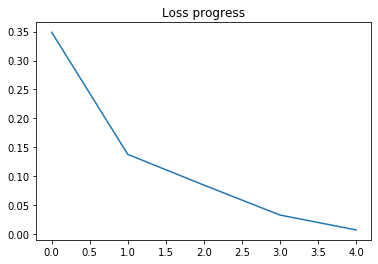

In [275]:
plt.plot(history.history['loss'])
plt.title('Loss progress');

Text(0.5, 1.0, 'accuracy progress')

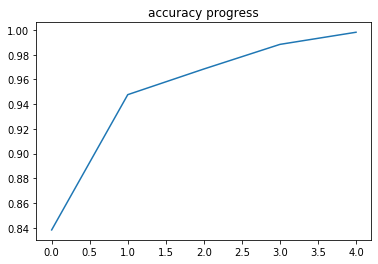

In [276]:
plt.plot(history.history['accuracy'])
plt.title('accuracy progress')

In [278]:
loss, accuracy, f1_score, precision, recall = Dcnn.evaluate(train_dataset, verbose=1)
print("Validacao")
print("loss: %.4f" % (loss))
print("acc: %.4f" % (accuracy))
print("f1_score: %.4f" % (f1_score))
print("precision: %.4f" % (precision))
print("recall: %.4f" % (recall))

704/704 [==============================] - 11s 16ms/step - loss: 0.0042 - accuracy: 0.9988 - f1_m: 0.9987 - precision_m: 0.9975 - recall_m: 1.0000
Validacao
loss: 0.0042
acc: 0.9988
f1_score: 0.9987
precision: 0.9975
recall: 1.0000


In [279]:
loss, accuracy, f1_score, precision, recall = Dcnn.evaluate(test_dataset, verbose=1)
print("Validacao")
print("loss: %.4f" % (loss))
print("acc: %.4f" % (accuracy))
print("f1_score: %.4f" % (f1_score))
print("precision: %.4f" % (precision))
print("recall: %.4f" % (recall))

78/78 [==============================] - 1s 7ms/step - loss: 0.4776 - accuracy: 0.9042 - f1_m: 0.9161 - precision_m: 0.8847 - recall_m: 0.9529
Validacao
loss: 0.4776
acc: 0.9042
f1_score: 0.9161
precision: 0.8847
recall: 0.9529
